# Fruit Classifier Project  🚀

Welcome to the Fruit Classifier Project! In this notebook we build and evaluate a deep learning pipeline to automatically recognize different types of fruit from images [[1]](#references). Leveraging a pretrained ResNet-18 backbone and standard data-augmentation techniques, you’ll see how to prepare a dataset, train a model, and measure its performance with confusion matrices and per-class accuracy. Along the way we’ll integrate FiftyOne for interactive data exploration and optionally track experiments with Weights & Biases. By the end, you’ll have a self-contained, reproducible workflow—from raw images all the way to a saved, deployable PyTorch model.  


## Table of Contents
- [0. Project Configuration](#0-project-configuration)
  - [0.1 Imports & global settings](#01-imports--global-settings)
  - [0.2 Detect accelerator (CUDA / CPU)](#02-detect-accelerator-cuda--cpu)
- [1. Data Acquisition](#1-data-acquisition)
  - [1.1 Download or mount the fruit dataset](#11-download-or-mount-the-fruit-dataset)
  - [1.2 Quick sanity-check of raw files](#12-quick-sanity-check-of-raw-files)
- [2. Exploratory Data Analysis](#2-exploratory-data-analysis)
  - [2.1 Visualise samples with FiftyOne](#21-visualise-samples-with-fiftyone)
  - [2.2 Class distribution](#22-class-distribution)
- [3. Data Preparation](#3-data-preparation)
  - [3.1 Config & logging](#31-config--logging)
  - [3.2 Train/Val/Test split (sklearn)](#32-trainvaltest-split-sklearn)
  - [3.3 Create & launch FiftyOne dataset from split](#33-create-and-launch-fiftyone-dataset-from-split)
  - [3.4 Custom `FruitDataset` class](#34-custom-fruitdataset-class)
  - [3.5 Data augmentation & preprocessing (TorchVision `transforms`)](#35-data-augmentation--preprocessing-torchvision-transforms)
- [4. Model Development](#4-model-development)
  - [4.1 Load pretrained ResNet-18 backbone](#41-load-pretrained-resnet-18-backbone)
  - [4.2 Replace classifier head for 6 classes](#42-replace-classifier-head-for-6-classes)
  - [4.3 Loss & metrics](#43-loss--metrics)
  - [4.4 Optimiser and LR schedule](#44-optimiser-and-lr-schedule)
- [5. Training](#5-training)
  - [5.1 Build DataLoaders](#51-build-dataloaders)
  - [5.2 Single-epoch validation (smoke test)](#52-single-epoch-validation-smoke-test)
  - [5.3 Training loop with checkpoints](#53-training-loop-with-checkpoints)
  - [5.4 Experiment tracking with Weights & Biases](#54-experiment-tracking-with-weights--biases)
- [6. Evaluation & Visualisation](#6-evaluation--visualisation)
  - [6.1 Confusion matrix and per-class accuracy](#61-confusion-matrix-and-per-class-accuracy)
  - [6.2 Precision, recall & F₁ scores](#611-precision-recall--f1-scores)
  - [6.3 Overlay predictions in FiftyOne](#62-overlay-predictions-in-fiftyone)
- [7. Inference Pipeline](#7-inference-pipeline)
  - [7.1 Helper to classify one image](#71-helper-to-classify-one-image)
  - [7.2 Batch inference on unseen data](#72-batch-inference-on-unseen-data)
- [8. Save, Export & Deployment](#8-save-export--deployment)
  - [8.1 Save inference-only checkpoint (`.pth`)](#81-save-inference-only-checkpoint-pth)
  - [8.2 Retrieve best model from Weights & Biases](#82-retrieve-best-model-from-weights--biases)
  - [8.3 Freeze environment (`pip freeze > requirements.txt`)](#83-freeze-environment-pip-freeze--requirementstxt)
  - [8.4 Build FastAPI classification endpoint](#84-build-fastapi-classification-endpoint)
  - [8.5 Dockerize the FastAPI app](#85-dockerize-the-fastapi-app)
  - [8.6 Deploy the Docker container](#86-deploy-the-docker-container)
- [9. Conclusions & Next Steps](#9-conclusions--next-steps)
- [References](#references)


## 0. Project Configuration  <a id="0-project-configuration"></a>


In this section, we will set up our environment by importing essential libraries, fixing random seeds for reproducibility, and identifying the compute device (CPU, GPU, or MPS) for training.


### 0.1 Imports & global settings  <a id="01-imports--global-settings"></a>

In [5]:
# Core Python & data libraries
import os
import random
from pathlib import Path
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import zipfile
import subprocess
import shutil

from PIL import Image

import fiftyone as fo
from fiftyone.types import ImageClassificationDirectoryTree
from fiftyone import ViewField as F


from sklearn.model_selection import train_test_split

from collections import Counter

import json


# PyTorch & vision
import torch
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import v2 as transforms
# model architecture
from torchvision.models import resnet18
# weights
from torchvision.models import ResNet18_Weights

import torch.nn as nn

import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import DataLoader

import wandb
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from fiftyone.utils.image import read as fo_read_image


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"✅ Imports completed and global seed set to {SEED}.")


✅ Imports completed and global seed set to 42.


Reprocubility settings ensure that all sources of randomness in our code produce the same outputs every time you run the notebook, which is critical for reproducibility:

- `random.seed(SEED)`  
  Sets the seed for Python’s built-in `random` module, so any calls like `random.random()` or `random.choice()` will follow a repeatable sequence.

- `np.random.seed(SEED)`  
  Seeds NumPy’s random number generator, making operations such as `np.random.randn()` or `np.random.shuffle()` deterministic.

- `torch.manual_seed(SEED)`  
  Initializes PyTorch’s CPU random number generator to a fixed state, so model weight initializations and any other CPU‐side randomness (e.g., `torch.rand()`) are repeatable.

- `torch.backends.cudnn.deterministic = True`  
  Forces CuDNN (NVIDIA’s GPU‐accelerated library for deep learning) to use only deterministic convolution algorithms. This guarantees that GPU operations yield the same results on each run, at the cost of sometimes being slower.

- `torch.backends.cudnn.benchmark = False`  
  Disables CuDNN’s autotuner that picks the fastest convolution algorithm based on your hardware and input sizes. With benchmarking off, the choice remains fixed and repeatable, preventing run‐to‐run variability.


### 0.2 Detect accelerator (CPU / GPU / MPS)  <a id="02-detect-accelerator-cpu--gpu--mps"></a>

In this step, we check for GPU support (CUDA) and fall back to CPU if neither is available, then assign the best device for training.


In [6]:
# Check for CUDA, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Data Acquisition  <a id="1-data-acquisition"></a>

In this section, we’ll fetch the fruit images—either by downloading and extracting an archive or mounting a drive—and then display a few random samples to verify everything’s in place.


### 1.1 Download the fruit dataset from Kaggle  <a id="11-download-or-mount-the-fruit-dataset"></a>

In this cell we’ll use the Kaggle API to pull down the “apples-bananas-oranges” dataset. You need to have your `KAGGLE_USERNAME` and `KAGGLE_KEY` set as environment variables (or stored in `~/.kaggle/kaggle.json`).


In [7]:
# Ensure your Kaggle credentials are available:
#  - Option A: export env vars in your shell:
#      export KAGGLE_USERNAME=your_username
#      export KAGGLE_KEY=your_key
#  - Option B: place a valid kaggle.json in ~/.kaggle/ with:
#      {"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}
#    and secure it:
#      chmod 600 ~/.kaggle/kaggle.json

# 1) Paths & Dataset
DATA_DIR = Path("data")
ZIP_PATH = DATA_DIR / "apples-bananas-oranges.zip"
KAGGLE_DATASET = "sriramr/apples-bananas-oranges"

# 2) Download the zip only if missing
if not ZIP_PATH.exists():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    print("⏬ Downloading dataset ZIP…")
    # Use subprocess to invoke the Kaggle CLI tool and download the dataset ZIP archive
    subprocess.run([
        "kaggle", "datasets", "download",
        "-d", KAGGLE_DATASET,
        "-p", str(DATA_DIR),
        "--force"       # overwrite if it exists
    ], check=True)
else:
    print("✅ ZIP already present, skipping download.")

# Only extract if the folder doesn't already exist
if not (DATA_DIR / "original_data_set").exists():
    print("⏬ Extracting original_data_set folder…")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        # Select only entries under original_data_set/ (files and subdirs)
        members = [m for m in z.namelist() if m.startswith("original_data_set/")]
        # Extract them all, preserving the folder structure
        for member in members:
            z.extract(member, path=str(DATA_DIR))
    print("✅ Extraction complete.")
else:
    print("✅ original_data_set folder already exists, skipping extraction")

✅ ZIP already present, skipping download.
✅ original_data_set folder already exists, skipping extraction


At this point, we see a second `original_data_set` folder inside the first. We can delete that inner folder outright—its contents are already present one level up.


In [8]:
# Path to the nested, redundant folder
nested = DATA_DIR / "original_data_set" / "original_data_set"

# If it exists, remove it entirely
if nested.exists() and nested.is_dir():
    print(f"🔄 Removing nested folder {nested} …")
    shutil.rmtree(nested)
    print("✅ Nested `original_data_set` removed.")
else:
    print("✅ No nested `original_data_set` folder found, skipping.")

✅ No nested `original_data_set` folder found, skipping.


### 1.2 Quick sanity‐check of raw files  <a id="12-quick-sanity-check-of-raw-files"></a>


In this step we’ll display one random image per class to verify that our extraction placed all fruit folders under `data/original_data_set/`.


Found 6 classes: ['freshbanana', 'rottenoranges', 'freshoranges', 'rottenapples', 'freshapples', 'rottenbanana']


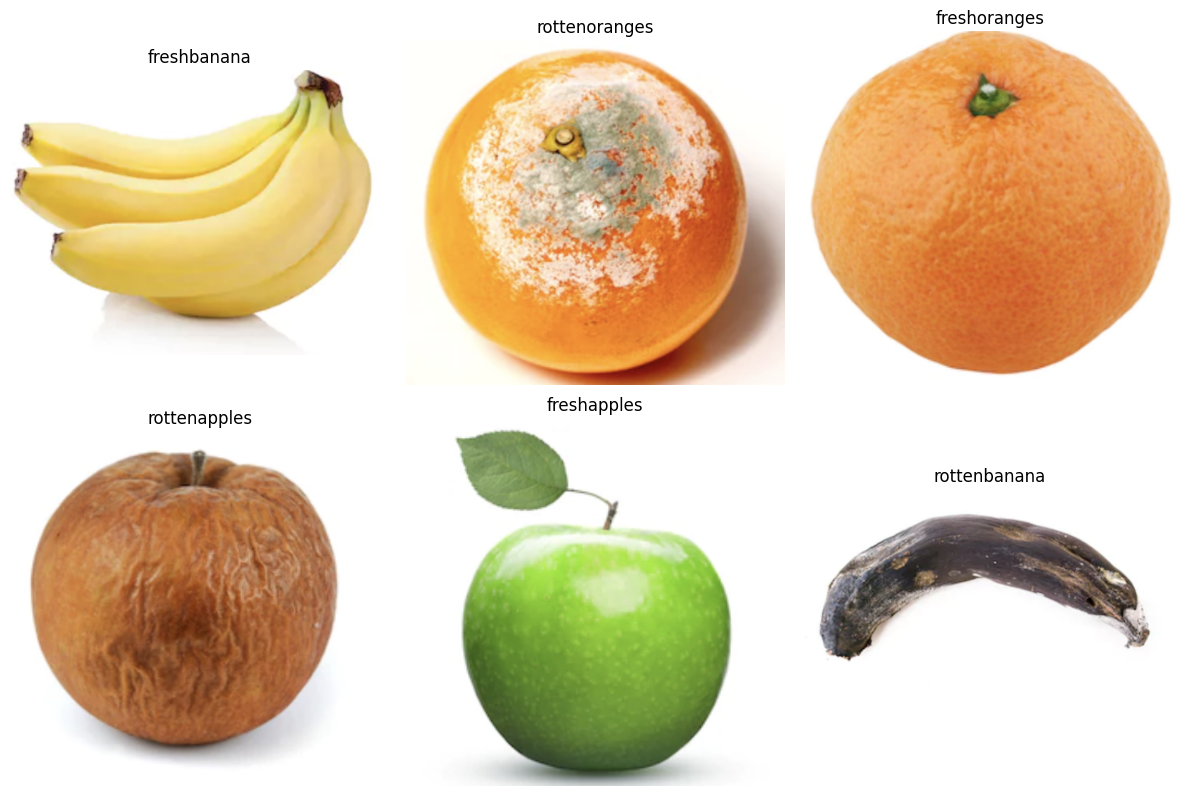

In [9]:
# Base directory where classes live
BASE_DIR = Path("data") / "original_data_set"

# Find all class subfolders (e.g., freshapples, rottenbananas, etc.)
classes = [p.name for p in BASE_DIR.iterdir() if p.is_dir()]
print(f"Found {len(classes)} classes:", classes)

# Plot one random image per class
n_cols = 3
n_rows = (len(classes) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for ax, cls in zip(axes, classes):
    cls_dir = BASE_DIR / cls
    img_files = list(cls_dir.glob("*"))
    img_path = random.choice(img_files)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

# Turn off any extra subplots
for ax in axes[len(classes):]:
    ax.axis("off")

plt.tight_layout()

## 2. Exploratory Data Analysis  <a id="2-exploratory-data-analysis"></a>


In this section, we’ll launch a FiftyOne dataset to interactively explore a few example images and their class labels.


### 2.1 Visualise samples with FiftyOne  <a id="21-visualise-samples-with-fiftyone"></a>


In [10]:
import fiftyone as fo
from fiftyone.types import ImageClassificationDirectoryTree
from pathlib import Path

# Path to the root folder containing class subdirectories
ROOT_DIR = Path("data") / "original_data_set"

# Clean up any previous FiftyOne dataset with this name
if fo.dataset_exists("fruit_classifier"):
    fo.delete_dataset("fruit_classifier")

# Create a FiftyOne dataset from our directory tree
dataset = fo.Dataset.from_dir(
    dataset_dir=str(ROOT_DIR),
    dataset_type=ImageClassificationDirectoryTree(),
    name="fruit_classifier"
)

# Launch the FiftyOne app in a new browser window/tab
session = fo.launch_app(
    dataset,
    browser=True       # open your default browser automatically
)

# Print and open the URL in your system browser
url = session.url
print("🚀 FiftyOne is running at:", url)

 100% |███████████████| 1512/1512 [649.7ms elapsed, 0s remaining, 2.3K samples/s]      
Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port


🚀 FiftyOne is running at: http://localhost:5151/


By default, in a notebook environment `fo.launch_app()` embeds a small iframe. To open the FiftyOne app in a full‐screen browser tab instead, click the session url.


**Why use `ImageClassificationDirectoryTree`?**

- **Automatic label inference**: it reads each subfolder name as a class label (e.g. `freshapples`, `freshbananas`, etc.).  
- **No extra annotation files**: you don’t need CSV/JSON metadata—just a directory-per-class layout.  
- **Scalable to any class count**: it discovers all folders under the root automatically, so adding new classes is as simple as creating a new folder.

### 2.2 Class distribution  <a id="22-class-distribution"></a>


In this cell we’ll compute and display how many images we have per class in our dataset.


,count
freshapples,232
freshbanana,218
freshoranges,206
rottenapples,327
rottenbanana,306
rottenoranges,222


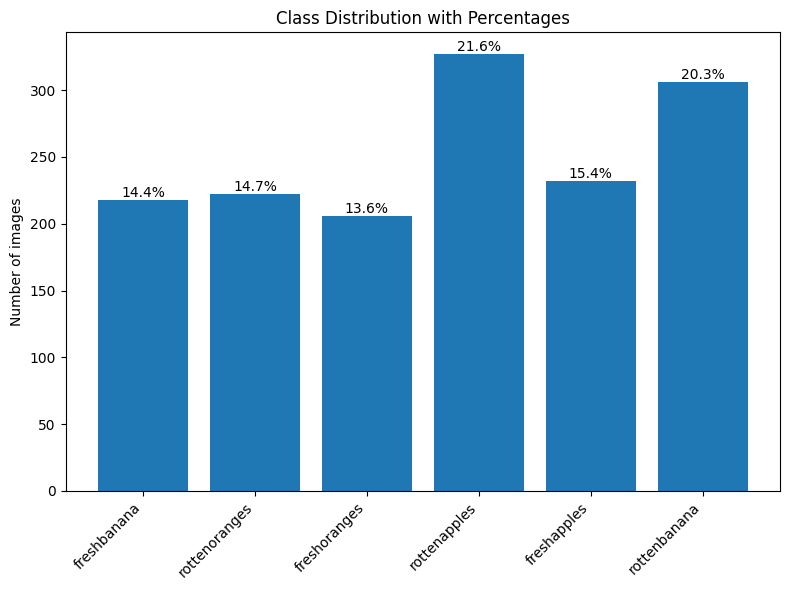

In [11]:
# Base directory where class folders are
BASE_DIR = Path("data") / "original_data_set"

# Count number of images in each class folder
class_counts = Counter({
    cls_dir.name: len(list(cls_dir.glob("*.png")))
    for cls_dir in BASE_DIR.iterdir()
    if cls_dir.is_dir()
})

# Display counts as a pandas DataFrame
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
display(df.sort_index())

# 3) Plot with percentages
classes = df.index.tolist()
counts = df["count"].tolist()
total = sum(counts)
percentages = [c / total * 100 for c in counts]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(classes, counts)
for idx, (cnt, pct) in enumerate(zip(counts, percentages)):
    ax.text(idx, cnt, f"{pct:.1f}%", ha="center", va="bottom")
ax.set_ylabel("Number of images")
ax.set_title("Class Distribution with Percentages")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 3. Data Preparation  <a id="3-data-preparation"></a>

In this section, we’ll split our images into training, validation, and test sets, implement a custom PyTorch `Dataset` to load them, and define our augmentation and preprocessing pipeline.  

### 3.1 Config & logging  <a id="31-config--logging"></a>


In this section, we define a central configuration dictionary in which we will store all hyperparameters and log them to ensure reproducibility and easy tracking of experiments. First, we record our train/validation/test split ratios.

In [12]:
# 3-way split ratios, hyperparameters, batch size, etc.
config_dict = {
    'train_ratio':         1/3,
    'val_ratio':           1/3,
    'test_ratio':          1/3,
}

# Log the configuration for reproducibility
print("🛠  Configuration:")
print(json.dumps(config_dict, indent=2))

🛠  Configuration:
{
  "train_ratio": 0.3333333333333333,
  "val_ratio": 0.3333333333333333,
  "test_ratio": 0.3333333333333333
}


### 3.2 Train/Val/Test split (sklearn)  <a id="32-trainvaltest-split-sklearn"></a>


In this step we’ll gather all image file paths and stratify‐split them into 70% train, 15% validation, and 15% test sets.


**What is a stratified split?**

When you split data, you often want each subset (train, val, test) to have the same class‐label proportions as the full dataset. By passing `stratify=labels` to `train_test_split`, scikit‐learn:

1. Groups your samples by their label.  
2. Randomly selects samples from each label group in proportion to its frequency in the original data.  

So if your dataset is 60% apples, 30% bananas, 10% oranges, each split will (approximately) preserve those percentages, preventing one subset from becoming un-balanced.


In [13]:
# Base directory containing class subfolders
ROOT_DIR = Path("data") / "original_data_set"

# List classes and create a mapping to integer labels
classes = sorted([d.name for d in ROOT_DIR.iterdir() if d.is_dir()])
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Gather filepaths & labels as before
filepaths, labels = [], []
for cls in classes:
    for img_path in (ROOT_DIR/cls).glob("*.png"):
        filepaths.append(img_path)
        labels.append(class_to_idx[cls])

# Compute sizes
train_ratio = config_dict['train_ratio']
val_ratio   = config_dict['val_ratio']
test_ratio  = config_dict['test_ratio']
assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

# First split: train vs temp
temp_size = val_ratio + test_ratio
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    filepaths, labels,
    test_size=temp_size,
    stratify=labels,
    random_state=SEED
)

# Second split: temp → val & test
val_prop = val_ratio / temp_size
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=1 - val_prop,
    stratify=temp_labels,
    random_state=SEED
)

print(f"✅ Splits:")
print(f"   Train:      {len(train_paths)} samples")
print(f"   Validation: {len(val_paths)} samples")
print(f"   Test:       {len(test_paths)} samples")

✅ Splits:
   Train:      503 samples
   Validation: 504 samples
   Test:       504 samples


> **Dataset splits**  
> We use a three-way split—**train**, **validation**, and **test**—to ensure robust model development and unbiased evaluation:
> 
> - **Train**: used for learning model parameters via gradient updates.  
> - **Validation**: used during training to tune hyper-parameters, perform early stopping, and select the best checkpoint.  
> - **Test**: held out until all training and validation decisions are complete; used only once for the final performance report (overall accuracy, confusion matrix, per-class metrics).  
> 
> This approach guarantees that our final metrics reflect true generalization to unseen data.  
 


### 3.3 Create & launch FiftyOne dataset from split  <a id="33-create-and-launch-fiftyone-dataset-from-split"></a>


Build a FiftyOne dataset from our `train_paths`/`train_labels` and `val_paths`/`val_labels`, tag each sample with its ground-truth label and split, then launch the app to inspect.


In [14]:
# Remove any existing dataset
if fo.dataset_exists("fruit-classification"):
    fo.delete_dataset("fruit-classification")

# Create new dataset
dataset = fo.Dataset(name="fruit-classification")

# Helper to add samples for a given split
def add_split(paths, labels, split_name):
    samples = []
    for fp, lbl in zip(paths, labels):
        sample = fo.Sample(filepath=str(fp))
        sample["ground_truth"] = fo.Classification(label=classes[lbl])
        sample["split"] = split_name
        samples.append(sample)
    dataset.add_samples(samples)

# Add train and validation samples
add_split(train_paths, train_labels, "train")
add_split(val_paths,   val_labels,   "validation")
add_split(test_paths,   test_labels,   "test")

print(dataset)

# Launch FiftyOne in your browser
session = fo.launch_app(dataset, auto=False)
print("FiftyOne is running at:", session.url)

 100% |█████████████████| 503/503 [127.0ms elapsed, 0s remaining, 4.0K samples/s]  
 100% |█████████████████| 504/504 [115.9ms elapsed, 0s remaining, 4.4K samples/s]     
 100% |█████████████████| 504/504 [116.1ms elapsed, 0s remaining, 4.4K samples/s]     
Name:        fruit-classification
Media type:  image
Num samples: 1511
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    split:            fiftyone.core.fields.StringField
Session launched. Run `session.show()` to open t

### 3.4 Custom `FruitDataset` class  <a id="34-custom-fruitdataset-class"></a>


In this step we define a PyTorch `Dataset` that wraps our lists of image file paths and integer labels, applying any `transform` pipeline on the fly.


In [15]:
class FruitDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        """
        Args:
            filepaths (List[Path or str]): paths to each image file
            labels    (List[int]):      corresponding integer class labels
            transform (callable, optional): torchvision transforms to apply
        """
        self.filepaths = filepaths
        self.labels    = labels
        self.transform = transform

    def __len__(self):
        # total number of samples
        return len(self.filepaths)

    def __getitem__(self, idx):
        # 1. Load image and label
        img_path = self.filepaths[idx]
        label    = self.labels[idx]

        # 2. Open image (and convert to RGB if needed)
        image = Image.open(img_path).convert("RGB")

        # 3. Apply transforms (e.g., resize, ToTensor, Normalize)
        if self.transform:
            image = self.transform(image)

        # 4. Return a (image_tensor, label) tuple
        return image, label

# Example instantiation:
# train_dataset = FruitDataset(train_paths, train_labels, transform=train_transform)
# val_dataset   = FruitDataset(val_paths,   val_labels,   transform=val_transform)

**Why define a custom `Dataset` class?**

- **Lazy, on-demand loading:** only reads images from disk in `__getitem__`, keeping memory usage low.  
- **Compatibility with `DataLoader`:** implements `__len__` and `__getitem__` so you automatically get batching, shuffling, and multi-worker loading.  
- **Seamless transform integration:** plug in any `torchvision.transforms` to apply augmentations, normalization, and conversions as samples are fetched.  
- **Maintainable, extensible code:** centralises file-path handling, label mapping, and preprocessing logic in one place, making it easy to extend (e.g. caching, custom sampling) without rewriting boilerplate.  


**Why convert images to RGB?**

- **Consistent input shape:** most computer‐vision models (especially pretrained ones) expect 3‐channel RGB inputs.  
- **Handle varied image modes:** source images might be  
  - **Grayscale (“L”):** single channel  
  - **RGBA:** RGB + alpha (transparency) channel  
  - **CMYK:** used in printing pipelines  
  - **P (palette-based):** indexed colors  
- By calling `.convert("RGB")`, we ensure every image has exactly three color channels in the expected order, avoiding shape or channel‐mismatch errors down the line.  


**Are `train_transform` and `val_transform` usually different?**

Yes—training transforms typically include **random augmentations** to help the model generalize, whereas validation transforms are **deterministic** so you get a stable evaluation set.


### 3.5 Data augmentation & preprocessing (TorchVision `transforms`)  <a id="35-data-augmentation--preprocessing-torchvision-transforms"></a>


In this cell we define our training and validation transform pipelines. We use `ToImage()` & `ToDtype()` in place of the deprecated `ToTensor()`.


In [16]:
# Training transforms: include random flips for augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),   # augmentation only on training
    transforms.RandomVerticalFlip(p=0.3),     # augmentation only on training
    transforms.ToImage(),                      # PIL→uint8 tensor
    transforms.ToDtype(torch.float32, scale=True),  # uint8→float32 [0–1]
    transforms.Normalize(
        [0.485, 0.456, 0.406],                # ImageNet mean
        [0.229, 0.224, 0.225]                 # ImageNet std
    ),
])

# Validation/Test transforms: deterministic
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    ),
])

# Log transform pipelines as lists of strings
config_dict['train_transforms'] = [repr(t) for t in train_transform.transforms]
config_dict['val_transforms']   = [repr(t) for t in val_transform.transforms]

# If you prefer just the transform class names:
# config_dict['train_transforms'] = [t.__class__.__name__ for t in train_transform.transforms]
# config_dict['val_transforms']   = [t.__class__.__name__ for t in val_transform.transforms]

# Print out the updated config
import json
print(json.dumps(config_dict, indent=2))

{
  "train_ratio": 0.3333333333333333,
  "val_ratio": 0.3333333333333333,
  "test_ratio": 0.3333333333333333,
  "train_transforms": [
    "Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)",
    "CenterCrop(size=(224, 224))",
    "RandomHorizontalFlip(p=0.5)",
    "RandomVerticalFlip(p=0.3)",
    "ToImage()",
    "ToDtype(scale=True)",
    "Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)"
  ],
  "val_transforms": [
    "Resize(size=[256], interpolation=InterpolationMode.BILINEAR, antialias=True)",
    "CenterCrop(size=(224, 224))",
    "ToImage()",
    "ToDtype(scale=True)",
    "Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)"
  ]
}


**Why Resize and CenterCrop?**

- **Match ResNet-18’s original training**: the ImageNet-trained ResNet-18 model expects inputs of size **224×224**—its authors used `Resize(256)` followed by `CenterCrop(224)` when training.  
- **Maintain aspect ratio then crop**: `Resize(256)` scales the shorter image side to 256 pixels, preserving the original aspect ratio, and `CenterCrop(224)` then extracts a centered 224×224 patch.  
- **Consistent input for pretrained weights**: by replicating the same preprocessing pipeline, we ensure our input distribution closely matches what the pretrained ResNet-18 saw, which helps the model generalize better when fine-tuning on our fruit dataset.  


**Why scale pixel values to [0–1] before normalization?**

- **Numerical stability:** neural networks train more reliably when inputs are small—values in the range [0–1] keep activations and gradients well‐conditioned, avoiding issues with large initial values.  
- **Consistent with pretrained models:** ResNet-18 (and most CV models) were trained on floating‐point images normalized from [0–1], so scaling ensures our fine-tuning inputs match that regime.  
- **Effective normalization:** the subsequent `Normalize(mean, std)` step assumes inputs are in [0–1]; scaling first guarantees that the mean/std centering and unit‐variance scaling operate correctly.  

**Why normalize input channels using mean and standard deviation?**

- **Centering the data:** subtracting the per-channel mean shifts each feature’s distribution to have zero mean, which helps the network learn weights more effectively and ensures activations stay centered.  
- **Unit variance scaling:** dividing by the per-channel standard deviation scales each channel to roughly unit variance, preventing any one channel from dominating the gradients and promoting balanced learning.  
- **Match pretrained statistics:** ResNet-18 was trained on ImageNet images that were normalized with these exact mean/std values (`[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]`), so using the same normalization ensures our inputs follow the same distribution the model expects.  
- **Faster convergence:** well-normalized inputs often lead to quicker and more stable training, as the optimizer doesn’t have to account for large, skewed input scales.  


## 4. Model Development  <a id="4-model-development"></a>

In this section, we’ll load an ImageNet-pretrained ResNet-18, swap its final layer for our 6-class fruit head, define our loss and evaluation metrics, and set up the optimizer with an appropriate learning-rate schedule.  

**What is ImageNet?**

ImageNet is a large‐scale, publicly available image database designed for visual object recognition research. It contains over 14 million labeled images spanning more than 20 000 object categories. 

The **ImageNet Large Scale Visual Recognition Challenge (ILSVRC)** is a yearly benchmark built on ImageNet. For ILSVRC, researchers selected a **subset of 1 000 categories** (e.g. “tabby cat”, “ambulance”, “strawberry”, etc.) and collected around **1.2 million training images**—which averages to roughly **1 200 images per category**. Models are trained and evaluated on this 1 000-class dataset to provide a standardized comparison of different architectures (ResNet, VGG, Inception, etc.).

By using a backbone pretrained on the ILSVRC 1 000-class subset, we leverage rich, general-purpose visual features (edges, textures, shapes) learned from millions of examples. This transfer learning approach typically yields faster convergence and higher accuracy on downstream tasks—such as our fruit classification—than training from scratch.  

**What is ResNet-18?**

ResNet-18 is a convolutional neural network architecture introduced by He et al. (2015) [[2]](#references) that leverages **residual learning** to train deeper models. It is called “18 layers deep” because its learnable layers consist of:

- **1 initial convolutional layer**  
- **8 residual blocks** arranged in 4 stages (2 blocks per stage), each block containing 2 convolutional layers  
- **1 final fully connected (FC) layer**  

Counting them gives:  
$$
1_{\text{conv stem}} + (8 \times 2)_{\text{conv in blocks}} + 1_{\text{FC}} = 18 \text{ layers}.
$$

Within each residual block, the input $\mathbf{x}$ is passed through two Conv–BN–ReLU layers to compute a residual mapping $\mathcal{F}(\mathbf{x})$, and then added back to the input via a skip connection:  
$$
\mathbf{y} = \mathcal{F}(\mathbf{x}) + \mathbf{x}.
$$

These skip connections help gradients flow directly through the network, mitigating the vanishing gradient problem and enabling effective training of deeper architectures. ResNet-18 strikes a strong balance between accuracy (∼11 million parameters) and efficiency—and its ImageNet-pretrained weights transfer well to downstream tasks like our fruit classification.  

![ResNet18 Architecture](images/ResNet_18.png)
*Figure 1.* ResNet 18 Architecture [[3]](#references).

**How a Residual Block Works**

A residual block lets the network learn a **residual mapping** via a “skip connection,” improving gradient flow and making very deep networks easier to train. Given an input tensor **x** of shape `(B, C_in, H, W)`, the block computes:

$$
\begin{aligned}
\textbf{Main path:}\quad
&\text{out} = \text{Conv1}(x)\quad\bigl(3\times3,\;C_{\text{out}},\;\text{stride}=s\bigr),\\
&\text{out} = \text{BN1}(\text{out}),\\
&\text{out} = \text{ReLU}(\text{out}),\\
&\text{out} = \text{Conv2}(\text{out})\quad\bigl(3\times3,\;C_{\text{out}},\;\text{stride}=1\bigr),\\
&\text{out} = \text{BN2}(\text{out})\quad\bigl(\text{shape }(B, C_{\text{out}}, H/s, W/s)\bigr).
\end{aligned}
$$

$$
\textbf{Skip path:}\quad
\text{identity} = 
\begin{cases}
x, & C_{\text{in}} = C_{\text{out}}\ \&\ s = 1,\\
\text{BN}_{\text{id}}\bigl(\text{Conv}_{\text{id}}(x)\bigr),
\quad\text{with }\text{Conv}_{\text{id}}\text{ a }1\times1\text{ conv (stride}=s\text{)},
\end{cases}
$$

$$
\mathbf{y} = \text{ReLU}\bigl(\text{out} + \text{identity}\bigr).
$$

**Why this helps**  
- **Dimensional matching:** a 1×1 conv in the skip path ensures `out` and `identity` share the same shape before addition.  
- **Improved gradient flow:** the skip connection creates a direct route for gradients, mitigating vanishing gradients in deep nets.  
- **Simplified learning:** optimizing the residual $F(x) = \text{out}$ is often easier than learning the full mapping $H(x)$ from scratch.  


**What is a 1×1 Convolution?**

A **1×1 convolution** is a convolutional layer whose kernel size is 1×1 (height × width). Even though it looks trivial spatially, it’s extremely useful for manipulating the **channel dimension** of a feature map while preserving its spatial resolution.

- **Operation**  
  Given an input tensor of shape  
  $$
    (B,\;C_{in},\;H,\;W)
  $$  
  a 1×1 conv with $C_{out}$ filters computes, at each spatial location $(h, w)$,  
  $$
    y_{b,c_{out},h,w}
    = \sum_{c_{in}=1}^{C_{in}}
        K_{c_{out},c_{in}} \;\times\;
        x_{b,c_{in},h,w}
    \quad\text{for }1 \le c_{out}\le C_{out}.
  $$  
  This is equivalent to applying a **fully-connected layer** across the channel dimension at every pixel.

- **Shape transformation**  
  - **Input:**  $(B,\,C_{in},\,H,\,W)$  
  - **Output:** $(B,\,C_{out},\,H,\;W)$  
  (assuming stride = 1 and no padding change)

- **Key uses in ResNets**  
  - **Channel projection:** when $C_{in}\neq C_{out}$, a 1×1 conv changes the number of channels so that two tensors can be added together in a residual block.  
  - **Downsampling:** if you use stride = 2, a 1×1 conv both halves the spatial dimensions $(H,W)$ and adjusts the channel count in the “skip” path to match the main path.  
  - **Bottleneck models:** in deeper ResNets (e.g. ResNet-50), 1×1 convs are used before and after a 3×3 conv to reduce then restore the channel dimension, greatly reducing computation.

- **Efficiency**  
  Despite touching every pixel, a 1×1 conv is much cheaper than larger kernels because it only multiplies across channels, not a spatial neighborhood.


### 4.1 Load pretrained ResNet-18 backbone  <a id="41-load-pretrained-resnet-18-backbone"></a>


In this step we’ll instantiate the ResNet-18 model pretrained on ImageNet and move it to our chosen device.


In [17]:
# 1. Specify the pretrained weights
weights = ResNet18_Weights.IMAGENET1K_V1

# 2. Load ResNet-18 with those weights
model = resnet18(weights=weights)

# 3. Move model to the selected device (CPU or CUDA)
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Inspecting the Pretrained Weights and Their Metadata**


In [18]:
# 1. Default weights enum member
print("Default weights:", ResNet18_Weights.DEFAULT)

# 2. What attributes and methods are available?
print("Available weight options:", dir(ResNet18_Weights.IMAGENET1K_V1))

# 3. Original transforms used during ImageNet training
original_transforms = ResNet18_Weights.IMAGENET1K_V1.transforms()
print("Original preprocessing pipeline:\n", original_transforms)

# Retrieve the list of ImageNet class names
categories = ResNet18_Weights.IMAGENET1K_V1.meta["categories"]

# Print how many categories there are
print(f"Number of ImageNet classes: {len(categories)}")

# 4. Metadata about the pretrained weights (including class names)
print("Weight metadata:\n", ResNet18_Weights.IMAGENET1K_V1.meta)


Default weights: ResNet18_Weights.IMAGENET1K_V1
Available weight options: ['__class__', '__doc__', '__eq__', '__hash__', '__module__', 'get_state_dict', 'meta', 'name', 'transforms', 'url', 'value', 'verify']
Original preprocessing pipeline:
 ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
Number of ImageNet classes: 1000
Weight metadata:
 {'min_size': (1, 1), 'categories': ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box t

### 4.2 Replace classifier head for 6 classes  <a id="42-replace-classifier-head-for-6-classes"></a>


In this step we swap out ResNet-18’s original 1000-way fully connected layer for a new head matching our 6 fruit classes.


In [19]:
# 1. Show the original classifier head
print("Original classifier head:", model.fc)

# 2. Replace with a two-layer Sequential head
model.fc = nn.Sequential(
    nn.Linear(in_features=model.fc.in_features, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=len(classes))  # 6 fruit classes
)

# 3. Move the new head to the correct device
model.fc = model.fc.to(device)

# 4. Verify the updated head
print("Updated classifier head:", model.fc)

Original classifier head: Linear(in_features=512, out_features=1000, bias=True)
Updated classifier head: Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=6, bias=True)
)


### 4.3 Loss & metrics  <a id="43-loss--metrics"></a>


In this cell we define our training objective and a simple accuracy metric for evaluation.


In [20]:
# 1) Loss function: Cross‐entropy for multi‐class classification
criterion = nn.CrossEntropyLoss()

# 2) Accuracy metric
def accuracy(logits, labels):
    """
    Computes the proportion of correct predictions in a batch.
    
    Args:
        logits: Tensor of shape (B, C) – raw model outputs (before softmax)
        labels: Tensor of shape (B,) – ground‐truth class indices
    Returns:
        acc: float – fraction of correct predictions
    """
    # Take the class with highest logit as the prediction
    preds = torch.argmax(logits, dim=1)
    # Compare to the true labels and take the mean
    return (preds == labels).float().mean().item() 
    # The `.item()` method converts a **one‐element** PyTorch tensor into 
    # a standard Python scalar (e.g. `float` or `int`). 


# Example usage:
# logits = torch.randn(8, 6)  # batch of 8, 6 classes
# labels = torch.randint(0, 6, (8,))
# print("Sample accuracy:", accuracy(logits, labels))

**Mathematical formulation of Cross‐Entropy Loss**

Let the model output a vector of logits $\mathbf{z} = (z_1,\dots,z_C)$ for $C$ classes. We convert these to a probability distribution via softmax:

$$
p_i = \frac{\exp(z_i)}{\sum_{j=1}^C \exp(z_j)}, \quad i=1,\dots,C.
$$

If the true class label is $t$ (so the one‐hot vector has $y_t=1$ and $y_i=0$ for $i\neq t$), the cross‐entropy loss for that sample is

$$
\begin{aligned}
\mathcal{L}(\mathbf{z}, t)
&= -\sum_{i=1}^C y_i \,\log p_i
= -\log p_t \\[6pt]
&= -\log\!\bigl(\tfrac{\exp(z_t)}{\sum_{j=1}^C \exp(z_j)}\bigr)
= -z_t + \log\!\Bigl(\sum_{j=1}^C \exp(z_j)\Bigr).
\end{aligned}
$$

For a batch of $N$ samples we average:

$$
\mathrm{CrossEntropyLoss}
= \frac{1}{N}\sum_{n=1}^N \mathcal{L}\bigl(\mathbf{z}^{(n)}, t^{(n)}\bigr).
$$

**Why use this loss?**

- Measures the “distance” between the true one‐hot distribution and the predicted softmax distribution.  
- Equivalent to the negative log‐likelihood of the correct class under the model’s predicted distribution.  
- A smooth, convex surrogate for the 0–1 classification error, providing stable gradients for optimization.   

### 4.4 Optimiser and LR schedule  <a id="44-optimiser-and-lr-schedule"></a>


In this cell we define our optimizer (AdamW) and a cosine‐annealing learning‐rate scheduler. We read hyperparameters from our `config_dict` (add them here if you haven’t already) and print everything to verify.


In [21]:
# Ensure your config_dict contains these entries:
#   'learning_rate', 'weight_decay', 'min_lr', 'training_epochs'
config_dict.update({
    'learning_rate':    3e-4,
    'weight_decay':     1e-4,
    'min_lr':           1e-6,
    'training_epochs':  10,
})

# Log optimizer config
print("🛠  Optimizer & scheduler config:")
print(json.dumps({k: config_dict[k] for k in 
                  ['learning_rate','weight_decay','min_lr','training_epochs']}, indent=2))

🛠  Optimizer & scheduler config:
{
  "learning_rate": 0.0003,
  "weight_decay": 0.0001,
  "min_lr": 1e-06,
  "training_epochs": 10
}


- **`learning_rate` (3e-4):** the initial step size for the optimizer when updating model weights; controls how quickly the model adapts to the data.  
- **`weight_decay` (1e-4):** L2 regularization coefficient that penalizes large weights, helping to prevent overfitting by encouraging simpler models.  
- **`min_lr` (1e-6):** the lowest learning rate value reached by the scheduler (cosine annealing) to avoid decaying to zero and allow a small amount of continued learning.  
- **`training_epochs` (10):** the number of full passes through the training dataset; determines how many times the model will see each example.  


In [22]:
# Instantiate AdamW optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config_dict['learning_rate'],
    weight_decay=config_dict['weight_decay']
)

# Print to verify
print("\n✅ Optimizer:", optimizer)


✅ Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.0001
)


**Primer: From SGD to AdamW**

Before diving into AdamW’s parameters, it helps to see how we got here:

1. **Stochastic Gradient Descent (SGD)**  
   We update weights $\theta$ by stepping in the negative gradient direction:  
   $$\theta_{t+1} = \theta_t - \alpha\,\nabla_\theta L(\theta_t),$$  
   where $\alpha$ is the learning rate. Because we use noisy minibatch gradients, vanilla SGD can “zig-zag” and converge slowly.

2. **Momentum**  
   To smooth those noisy updates, we keep a running average of past gradients (the **first moment**):  
   $$
     m_t = \beta_1\,m_{t-1} \;+\;(1-\beta_1)\,g_t,
     \quad
     \theta_{t+1} = \theta_t - \alpha\,m_t.
   $$  
   Here $g_t=\nabla_\theta L(\theta_t)$ and $\beta_1$ (e.g.\ 0.9) controls how much history to remember.

3. **Adaptive rates (RMSProp)**  
   Instead of a single $\alpha$, RMSProp tracks the **second moment** (squared gradients):  
   $$
     v_t = \beta_2\,v_{t-1} \;+\;(1-\beta_2)\,g_t^2,
     \quad
     \theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{v_t} + \epsilon}\,g_t.
   $$  
   This rescales each parameter’s step by its recent gradient magnitude.

4. **Adam**  
   Adam merges momentum and RMSProp:  
   $$
     m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t,\quad
     v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2,
   $$
   applies **bias correction** $\hat m_t=m_t/(1-\beta_1^t)$, $\hat v_t=v_t/(1-\beta_2^t)$, and updates:  
   $$
     \theta_{t+1} = \theta_t - \alpha\,\frac{\hat m_t}{\sqrt{\hat v_t} + \epsilon}.
   $$  
   - $\beta_1$ smooths the **average gradient** (momentum).  
   - $\beta_2$ smooths the **average squared gradient** (adaptive rate).  
   - $\epsilon$ prevents division by zero when $\hat v_t$ is very small.

5. **AdamW & AMSGrad**  
    - **`amsgrad`**  
      - **What it is:** A variant of Adam that keeps track of the maximum of past squared gradients rather than the exponential average.  
      - **Why it exists:** The original Adam can sometimes fail to converge on certain pathological problems; AMSGrad imposes a non-increasing second‐moment estimate which has a theoretical convergence guarantee.  
      - **Trade‐off:** Slightly more memory (to store the max of  vs.  averages) and a bit slower, but potentially more stable training on tricky loss landscapes.

    - **`betas = (β₁, β₂)`**  
      - **β₁ (0.9):** Decay rate for the **first moment** (the running mean of gradients). A value close to 1 “smooths” the gradient estimate over more steps.  
      - **β₂ (0.999):** Decay rate for the **second moment** (the running mean of squared gradients). A high value ensures variance estimates change slowly.  
      - **Purpose:** These two hyperparameters control the balance between stability (large β) and adaptivity (small β). Tuning them can help in very noisy or very sparse gradient settings.

    - **`eps`**  
      - **What it is:** A tiny constant (1e‐8) added inside the square‐root of the second‐moment denominator:  
    $$\hat{v}_t = \beta_2 \hat{v}_{t-1} + (1-\beta_2) g_t^2$$  
    $$\theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$  
      - **Why it’s needed:** Prevents division by zero or extremely small variances that would blow up the update step.  
      - **Effect of changing:** Larger → more damping (updates smaller); smaller → more sensitivity (risk numerical instability).

    - **`weight_decay`**  
      - **What it is:** The coefficient λ in the L2‐regularization penalty added to the loss, implemented in AdamW as a **decoupled** term:  
    $$\theta_{t+1} = \theta_t - \alpha\bigl(\frac{\hat{m}_t}{\sqrt{\hat{v}_t}+\epsilon} + \lambda\,\theta_t\bigr)$$  
      - **Why “decoupled”?** Unlike classic L2 (which is baked into the gradient), AdamW applies weight decay as a separate step. This gives clearer control over regularization strength regardless of Adam’s moment estimates.  
      - **Effect of changing:** Higher → stronger push toward zero weights (more regularization); lower → weaker regularization (risk overfitting).

    - **`capturable`**  
      - **What it is:** A flag that, when `True`, makes the optimizer’s update step compatible with **CUDA Graphs** capture. CUDA Graphs let you record a sequence of GPU operations once and replay them with minimal overhead.  
      - **When you need it:** In ultra‐high‐performance settings where you launch identical training steps thousands of times per second and want to eliminate Python overhead.  
      - **Default (`False`):** Most users don’t need CUDA Graphs, so the simpler, non‐capturable path is used.

    - **`differentiable`**  
      - **What it is:** If `True`, the optimizer’s update itself becomes part of PyTorch’s autograd graph (so you can compute gradients through an optimization step).  
      - **Use case:** Meta‐learning or hyperparameter optimization, where you need to differentiate through the training process.  
      - **Default (`False`):** Standard training doesn’t require this, so it’s turned off to save memory and computation.

    - **`foreach`**  
      - **What it is:** Controls use of **`torch._foreach`** kernels, which batch together elementwise operations (like updating each parameter tensor) into a single fused call.  
      - **Benefit:** Can be significantly faster when updating many small tensors, since it reduces Python‐to‐C++ call overhead.  
      - **Options:**  
        - `True`: force use of foreach kernels  
        - `False`: never use them  
        - `None`: let PyTorch auto‐decide based on tensor sizes and environment  

    - **`fused`**  
      - **What it is:** When `True`, uses **fused** optimizer kernels (combining multiple ops—e.g., momentum update, weight decay—into a single CUDA kernel) for maximum speed.  
      - **Availability:** Depends on whether you installed a build of PyTorch that includes these specialized kernels.  
      - **Default (`None`):** Auto‐selects the best implementation available; if you want to force it, you can set `fused=True` or `False`.

---

With this foundation, the roles of **`betas`**, **`eps`**, and **`amsgrad`** become clear: they control how we average gradients versus squared gradients, stabilize small denominators, and ensure robust convergence. 

By understanding these options, you can tailor AdamW to your hardware (GPUs vs. CPUs), performance needs (normal training vs. meta‐learning vs. ultra‐fast loops), and regularization preferences.  

In [23]:
# Cosine Annealing LR scheduler
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=config_dict['training_epochs'],
    eta_min=config_dict['min_lr']
)

# Print to verify
print("✅ LR Scheduler:", scheduler)

✅ LR Scheduler: <torch.optim.lr_scheduler.CosineAnnealingLR object at 0x7e924c21e780>


**What is the Cosine Annealing LR Scheduler?**

The Cosine Annealing learning‐rate scheduler gradually decreases the learning rate from an initial value $\eta_{\max}$ down to a minimum $\eta_{\min}$ following the first half‐period of a cosine curve over $T_{\max}$ steps. Concretely, at epoch (or step) $t$, the LR is

$$
\eta_t = \eta_{\min} \;+\; \tfrac{1}{2}(\eta_{\max} - \eta_{\min})\Bigl(1 + \cos\!\bigl(\tfrac{t}{T_{\max}}\pi\bigr)\Bigr).
$$

- **Starts high** at $\eta_0 = \eta_{\max}$.  
- **Ends low** at $\eta_{T_{\max}} = \eta_{\min}$.  
- **Smooth, non‐monotonic decay** gives large updates early on and very fine updates near the end.  
- Often helps escape shallow minima and improves final convergence compared to simple step or exponential decay schedules.  

## 5. Training  <a id="5-training"></a>


In this section, we’ll set up our `DataLoader`s to efficiently batch the training, validation, and test datasets, and shuffle the training dataset. We’ll perform a quick “smoke test” to confirm our model and data pipeline work end-to-end, then build a full training loop with loss tracking, validation accuracy monitoring, learning-rate scheduling, and checkpointing of the best model. Finally, we’ll show how to integrate Weights & Biases for experiment logging and visualization.  


### 5.1 Build DataLoaders  <a id="51-build-dataloaders"></a>


In [24]:
# Create PyTorch datasets
train_dataset = FruitDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = FruitDataset(val_paths,   val_labels,   transform=val_transform)
test_dataset  = FruitDataset(test_paths,  test_labels,  transform=val_transform)

# Build DataLoaders
batch_size = config_dict.get('training_batch_size', 64)
train_loader = DataLoader(
    train_dataset,        # The dataset object to load data from
    batch_size=batch_size,# Number of samples per batch; controls memory vs. update frequency
    shuffle=True,         # Randomize the sample order every epoch for better generalization
    num_workers=4,        # Number of subprocesses to use for parallel data loading
    pin_memory=True       # Allocate batches in page-locked (pinned) memory for faster GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"🚂 Train batches: {len(train_loader)} | 🔍 Val batches: {len(val_loader)} | 🎯 Test batches: {len(test_loader)}")

🚂 Train batches: 8 | 🔍 Val batches: 8 | 🎯 Test batches: 8


### 5.2 Single‐epoch validation (smoke test) <a id="52-single-epoch-validation-smoke-test"></a>

In [25]:
# Quick check: run one batch through the model in eval mode

model.eval()  # switch model to evaluation mode (disables dropout, uses running stats for BatchNorm)

with torch.no_grad():  # disable gradient computation for efficiency (no backward pass)
    batch = next(iter(val_loader))   # get the first batch from the validation DataLoader
    xb, yb = batch                  # unpack inputs (xb) and labels (yb)
    xb, yb = xb.to(device), yb.to(device)  # move data and labels to the selected device (CPU/GPU)
    
    logits = model(xb)              # forward pass: compute raw model outputs
    acc = accuracy(logits, yb)      # compute accuracy metric for this batch
    
    print(f"🔍 Validation accuracy (1 batch): {acc*100:.2f}%")

🔍 Validation accuracy (1 batch): 20.31%


### 5.3 Training loop with checkpoints <a id="53-training-loop-with-checkpoints"></a>

In [26]:
from tqdm import tqdm
import torch
from pathlib import Path

# 1. Prepare to track losses and best model
train_losses = []
val_losses   = []
best_val_loss = float('inf')
best_model_weights = None

# 2. Checkpoint directory
checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
best_ckpt_path = checkpoint_dir / "best_model.pth"

# 3. Training + validation loop
for epoch in range(1, config_dict['training_epochs'] + 1):
    # --- Training pass ---
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss     += loss.item() * xb.size(0)
        preds             = torch.argmax(logits, dim=1)
        running_corrects += (preds == yb).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_corrects / len(train_loader.dataset)
    train_losses.append(epoch_loss)   # record training loss

    # --- Validation pass ---
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for xb, yb in tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False):
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)

            val_running_loss     += loss.item() * xb.size(0)
            preds                  = torch.argmax(logits, dim=1)
            val_running_corrects += (preds == yb).sum().item()

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc  = val_running_corrects / len(val_loader.dataset)
    val_losses.append(val_loss)       # record validation loss

    # --- Scheduler step ---
    scheduler.step()

    # --- Logging to console ---
    print(
        f"Epoch {epoch}/{config_dict['training_epochs']} — "
        f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc*100:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%"
    )

    # --- Checkpoint best model by validation loss ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()   # stash best weights
        torch.save(best_model_weights, best_ckpt_path)
        print(f"✅ New best model saved (val_loss={best_val_loss:.4f}) → {best_ckpt_path}")

# After training:
# - train_losses, val_losses hold per-epoch losses
# - best_val_loss and best_model_weights reference the best model


Epoch 1/10 — Train Loss: 0.8246, Train Acc: 80.52% | Val Loss: 0.2414, Val Acc: 92.06%
✅ New best model saved (val_loss=0.2414) → checkpoints/best_model.pth


Epoch 2/10 — Train Loss: 0.1109, Train Acc: 96.42% | Val Loss: 0.2436, Val Acc: 93.06%


Epoch 3/10 — Train Loss: 0.0282, Train Acc: 99.60% | Val Loss: 0.1478, Val Acc: 97.82%
✅ New best model saved (val_loss=0.1478) → checkpoints/best_model.pth


Epoch 4/10 — Train Loss: 0.0398, Train Acc: 98.81% | Val Loss: 0.1092, Val Acc: 97.62%
✅ New best model saved (val_loss=0.1092) → checkpoints/best_model.pth


Epoch 5/10 — Train Loss: 0.0314, Train Acc: 98.81% | Val Loss: 0.1135, Val Acc: 97.02%


Epoch 6/10 — Train Loss: 0.0130, Train Acc: 99.60% | Val Loss: 0.0833, Val Acc: 97.02%
✅ New best model saved (val_loss=0.0833) → checkpoints/best_model.pth


Epoch 7/10 — Train Loss: 0.0136, Train Acc: 99.60% | Val Loss: 0.0680, Val Acc: 97.82%
✅ New best model saved (val_loss=0.0680) → checkpoints/best_model.pth


Epoch 8/10 — Train Loss: 0.0127, Train Acc: 99.80% | Val Loss: 0.0687, Val Acc: 98.21%


Epoch 9/10 — Train Loss: 0.0054, Train Acc: 100.00% | Val Loss: 0.0647, Val Acc: 97.42%
✅ New best model saved (val_loss=0.0647) → checkpoints/best_model.pth


Epoch 10/10 — Train Loss: 0.0076, Train Acc: 99.80% | Val Loss: 0.0645, Val Acc: 97.82%
✅ New best model saved (val_loss=0.0645) → checkpoints/best_model.pth


### 5.4 Optional: experiment tracking with Weights & Biases <a id="54-optional-experiment-tracking-with-weights--biases"></a>

Below is a snippet showing how you can integrate `wandb.log` into your training/validation loop, so that each epoch you record both the loss and accuracy for the train and validation phases, plus the current learning rate:


Before you can call `wandb.init()` you need to authenticate your machine with your W&B account

In [27]:
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: minealsan (minealsan-dsr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [46]:
# 1. Prepare to track & save the best model + loss curves
train_losses = []                                 # will hold one entry per epoch
val_losses   = []
best_val_loss = float('inf')
best_model_weights = None

checkpoint_dir = Path("checkpoints")
checkpoint_dir.mkdir(exist_ok=True)
best_ckpt_path = checkpoint_dir / "best_model.pth"

# 2. Initialize W&B
wandb.init(project="fruit-classifier", config=config_dict)
wandb.watch(model, log="all", log_freq=100)

# 3. Training + validation loop with best‐model logic
for epoch in range(1, config_dict['training_epochs'] + 1):
    logs = {}

    for phase, loader in [("train", train_loader), ("validation", val_loader)]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        loop = tqdm(loader, desc=f"Epoch {epoch} [{phase}]", leave=False)
        with torch.set_grad_enabled(phase == "train"):
            for xb, yb in loop:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

                preds = torch.argmax(logits, dim=1)
                running_loss     += loss.item() * xb.size(0)
                running_corrects += (preds == yb).sum().item()

                loop.set_postfix({
                    f"{phase}_loss": running_loss / ((loop.n + 1) * loader.batch_size),
                    f"{phase}_acc":  running_corrects / ((loop.n + 1) * loader.batch_size)
                })

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc  = running_corrects / len(loader.dataset)

        if phase == "train":
            scheduler.step()

        # record metrics for this phase
        logs[f"{phase}_loss"]     = epoch_loss
        logs[f"{phase}_accuracy"] = epoch_acc

    # 4. Add common metrics and log to W&B
    logs["epoch"]         = epoch
    logs["learning_rate"] = optimizer.param_groups[0]["lr"]
    wandb.log(logs)

    # 5. Store losses for later plotting
    train_losses.append(logs["train_loss"])
    val_losses.append(logs["validation_loss"])

    print(
        f"Epoch {epoch} — "
        f"Train Loss: {logs['train_loss']:.4f}, "
        f"Train Acc: {logs['train_accuracy']*100:.2f}% | "
        f"Val Loss: {logs['validation_loss']:.4f}, "
        f"Val Acc: {logs['validation_accuracy']*100:.2f}%"
    )

    # 6. Check for new best model (by lowest validation loss)
    val_loss = logs["validation_loss"]
    if val_loss < best_val_loss:
        best_val_loss       = val_loss
        best_model_weights  = model.state_dict()       # stash best weights in-memory
        torch.save(best_model_weights, best_ckpt_path) # overwrite on disk
        print(f"✅ New best model saved (val_loss={best_val_loss:.4f}) → {best_ckpt_path}")

# After the loop, you have:
#  - train_losses and val_losses lists (len = training_epochs)
#  - best_val_loss, best_model_weights, and best_model.pth on disk


epoch,▁█
learning_rate,█▁
train_accuracy,█▁
train_loss,▁█
validation_accuracy,█▁
validation_loss,▁█
epoch,2
learning_rate,0.00027
train_accuracy,0.94235
train_loss,0.18403
validation_accuracy,0.81944


Epoch 1 — Train Loss: 0.1079, Train Acc: 96.82% | Val Loss: 0.4354, Val Acc: 89.48%
✅ New best model saved (val_loss=0.4354) → checkpoints/best_model.pth


Epoch 2 — Train Loss: 0.0634, Train Acc: 97.81% | Val Loss: 0.4065, Val Acc: 90.28%
✅ New best model saved (val_loss=0.4065) → checkpoints/best_model.pth


Epoch 3 — Train Loss: 0.0372, Train Acc: 99.01% | Val Loss: 0.1405, Val Acc: 95.24%
✅ New best model saved (val_loss=0.1405) → checkpoints/best_model.pth


Epoch 4 — Train Loss: 0.0246, Train Acc: 99.20% | Val Loss: 0.1230, Val Acc: 95.83%
✅ New best model saved (val_loss=0.1230) → checkpoints/best_model.pth


Epoch 5 — Train Loss: 0.0228, Train Acc: 99.60% | Val Loss: 0.1140, Val Acc: 96.03%
✅ New best model saved (val_loss=0.1140) → checkpoints/best_model.pth


Epoch 6 — Train Loss: 0.0268, Train Acc: 98.81% | Val Loss: 0.0986, Val Acc: 97.42%
✅ New best model saved (val_loss=0.0986) → checkpoints/best_model.pth


Epoch 7 — Train Loss: 0.0081, Train Acc: 99.80% | Val Loss: 0.0985, Val Acc: 97.62%
✅ New best model saved (val_loss=0.0985) → checkpoints/best_model.pth


Epoch 8 — Train Loss: 0.0131, Train Acc: 99.80% | Val Loss: 0.0948, Val Acc: 97.62%
✅ New best model saved (val_loss=0.0948) → checkpoints/best_model.pth


Epoch 9 — Train Loss: 0.0046, Train Acc: 100.00% | Val Loss: 0.0945, Val Acc: 97.62%
✅ New best model saved (val_loss=0.0945) → checkpoints/best_model.pth


Epoch 10 — Train Loss: 0.0054, Train Acc: 100.00% | Val Loss: 0.0942, Val Acc: 97.62%
✅ New best model saved (val_loss=0.0942) → checkpoints/best_model.pth


epoch,▁▂▃▃▄▅▆▆▇█
learning_rate,█▇▅▄▃▂▁▁▁▂
train_accuracy,▁▃▆▆▇▅████
train_loss,█▅▃▂▂▃▁▂▁▁
validation_accuracy,▁▂▆▆▇█████
validation_loss,█▇▂▂▁▁▁▁▁▁
epoch,10
learning_rate,3e-05
train_accuracy,1
train_loss,0.00543
validation_accuracy,0.97619


In [52]:
import wandb
import os

# 1) Start a fresh run
run = wandb.init(project="fruit-classifier", job_type="upload-best")

# 2) Re–create the artifact and add the file
artifact = wandb.Artifact(
    name="resnet18-fruit-best",
    type="model",
    description="Best ResNet-18 fruit classifier checkpoint",
)
artifact.add_file(str(best_ckpt_path))

# 3) Log the artifact via the run object
run.log_artifact(artifact)

# 4) Force a sync and finish
run.finish()  

# 5) Immediately re–open it and list its contents
check = wandb.init(project="fruit-classifier", job_type="check-artifact")
art = check.use_artifact("resnet18-fruit-best:latest", type="model")
artifact_dir = art.download()
print("✅ Files in artifact:", os.listdir(artifact_dir))
check.finish()


wandb:   1 of 1 files downloaded.  


✅ Files in artifact: ['best_model.pth']


After training, we load the best‐performing model, plot the epoch‐wise training and validation losses, and log the figure to W&B.



Training complete. Best validation loss: 0.0637


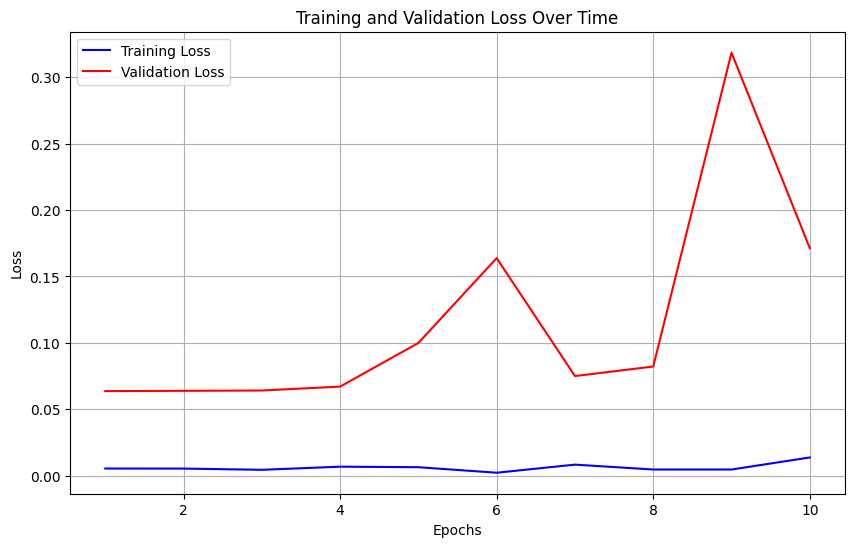

Training losses per epoch: [0.00546, 0.00541, 0.00448, 0.00684, 0.00644, 0.00229, 0.00838, 0.00471, 0.0047, 0.01378]
Validation losses per epoch: [0.0637, 0.06392, 0.06416, 0.06709, 0.09995, 0.1638, 0.07503, 0.08222, 0.31836, 0.1713]


<Figure size 640x480 with 0 Axes>

In [29]:
# 1. Report completion and best validation loss
print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")

# 2. Load best model weights (saved during training)
model.load_state_dict(best_model_weights)
model = model.to(device)

# 3. Plot training & validation loss curves
plt.figure(figsize=(10, 6))
epochs = range(1, config_dict['training_epochs'] + 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')     # blue line
plt.plot(epochs, val_losses,   'r-', label='Validation Loss')   # red line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. Log the plot image to Weights & Biases
#    wandb.Image can wrap the current matplotlib figure
wandb.log({"loss_curves": wandb.Image(plt)})

# 5. Print raw loss lists for reproducibility
print("Training losses per epoch:",  [round(x, 5) for x in train_losses])
print("Validation losses per epoch:",  [round(x, 5) for x in val_losses])

## 6. Evaluation & Visualisation  <a id="6-evaluation--visualisation"></a>


In this section, we’ll run our best model on the test set to compute a confusion matrix and per-class accuracy, and then overlay the model’s predictions on sample images using FiftyOne.  


### 6.1 Confusion matrix and per-class accuracy  <a id="61-confusion-matrix-and-per-class-accuracy"></a>


In [47]:
# 1) Run inference on the test set and collect true vs. predicted labels
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 2) Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = classes  # list of your 6 fruit class names

# 3) Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 4) Print per-class accuracy and other metrics
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

AttributeError: 'NoneType' object has no attribute '_log'

### 6.2 Overlay predictions in FiftyOne <a id="62-overlay-predictions-in-fiftyone"></a>

In [ ]:
# 1) Load the test dataset into FiftyOne
if fo.dataset_exists("fruit-test"):
    fo.delete_dataset("fruit-test")

test_ds = fo.Dataset("fruit-test")
samples = []

for fp, true_label in zip(test_paths, test_labels):
    sample = fo.Sample(filepath=str(fp))
    sample["ground_truth"] = fo.Classification(label=classes[true_label])
    samples.append(sample)

test_ds.add_samples(samples)

# 2) Run model predictions and save them to FiftyOne
predictions = []
for sample in test_ds:
    img = fo_read_image(sample.filepath)  
    logits = model(torch.from_numpy(img)  # 1) Wrap the NumPy array (H, W, C) as a torch.Tensor
                        .permute(2, 0, 1)         # 2) Reorder dimensions to (C, H, W)
                        .unsqueeze(0)             # 3) Add a leading batch dimension → (1, C, H, W
                        .float().to(device))
    pred = classes[torch.argmax(logits, dim=1).item()]
    sample["prediction"] = fo.Classification(label=pred)
    sample.save()

# 3) Launch the FiftyOne app filtered to incorrect predictions
view = test_ds.match(F("ground_truth") != F("prediction"))
session = fo.launch_app(view, auto=False)
print("FiftyOne running at:", session.url)

## 7. Inference Pipeline  <a id="7-inference-pipeline"></a>


In this section we define a simple function to classify a single image with our trained model, and then show how to run it over a folder of unseen images for batch inference.


### 7.1 Helper to classify one image  <a id="71-helper-to-classify-one-image"></a>


In [ ]:
def classify_image(image_path, model, transform, classes, device):
    """
    Load an image, apply preprocessing, and return the predicted class and confidence.

    Args:
        image_path (str or Path): path to the image file
        model (torch.nn.Module): trained model
        transform (callable): preprocessing pipeline (e.g. val_transform)
        classes (List[str]): list of class names
        device (torch.device): CPU or CUDA

    Returns:
        pred_label (str), confidence (float)
    """
    # 1. Load and preprocess
    img = Image.open(image_path).convert("RGB")
    x   = transform(img)                # e.g. Resize, ToImage, ToDtype, Normalize
    x   = x.unsqueeze(0).to(device)     # add batch dim → (1,C,H,W)

    # 2. Forward pass
    model.eval()
    with torch.no_grad():
        logits = model(x)              
        probs  = torch.softmax(logits, dim=1)
        conf, idx = torch.max(probs, dim=1)

    # 3. Map to label
    pred_label = classes[idx.item()]
    confidence = conf.item()

    return pred_label, confidence

# Example usage:
# img_path = "data/unseen/apple123.png"
# label, score = classify_image(img_path, model, val_transform, classes, device)
# print(f"Predicted: {label} ({score*100:.1f}%)")


### 7.2 Batch inference on unseen data <a id="72-batch-inference-on-unseen-data"></a>

In [ ]:
from pathlib import Path
import pandas as pd

def batch_inference(folder_path, model, transform, classes, device):
    """
    Run inference on all images in folder_path and return a DataFrame of results.
    """
    folder = Path(folder_path)
    results = []

    for img_file in folder.rglob("*.*"):  # recursively find any file
        try:
            label, conf = classify_image(img_file, model, transform, classes, device)
            results.append({
                "filepath": str(img_file),
                "prediction": label,
                "confidence": conf
            })
        except Exception as e:
            print(f"⚠️ Skipping {img_file}: {e}")

    return pd.DataFrame(results)

# Run batch inference
unseen_folder = "data/unseen"
df_preds = batch_inference(unseen_folder, model, val_transform, classes, device)

# Show results
display(df_preds.head())

# (Optional) save to CSV
df_preds.to_csv("inference_results.csv", index=False)


## 8. Save, Export & Deployment <a id="8-save-export--deployment"></a>

In this section, we’ll take our trained ResNet-18 fruit classifier from experimentation to production. We’ll start by serializing the best model checkpoint to disk, then show how to retrieve artifacts from Weights & Biases and lock down our Python environment with a `requirements.txt`. Next, we’ll optionally publish the model on the Hugging Face Hub before building a lightweight FastAPI service for inference. Finally, we’ll containerize that service with Docker and walk through deploying the container so your classifier can serve predictions in a real-world setting.

### 8.1 Save inference-only checkpoint (`.pth`) <a id="81-save-inference-only-checkpoint-pth"></a>

Here, we create a minimal checkpoint containing only the model state and class labels—ideal for deployment.

In [48]:
# Path to your original checkpoint
orig_ckpt = "checkpoints/best_model.pth"

# Load the checkpoint
checkpoint = torch.load(orig_ckpt, map_location="cpu")

# Determine checkpoint type
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    print("✅ Loaded full checkpoint (with optimizer & metadata)")
    state_dict = checkpoint["model_state_dict"]
    classes = checkpoint.get("classes", classes)  # fallback if classes already defined
elif isinstance(checkpoint, dict):
    print("⚠️ Loaded a dict without 'model_state_dict'; treating it as a raw state_dict")
    state_dict = checkpoint
    # Ensure `classes` is defined
    try:
        classes
    except NameError:
        classes = [
            "freshapples",
            "freshbanana",
            "freshoranges",
            "rottenapples",
            "rottenbanana",
            "rottenoranges",
        ]
else:
    raise ValueError(f"Unexpected checkpoint format: {type(checkpoint)}")

# Build the distilled, inference-only checkpoint
inference_ckpt = {
    "model_state_dict": state_dict,
    "classes": classes,
}

# Save it out to a lighter-weight file
export_dir = "exported"
os.makedirs(export_dir, exist_ok=True)
export_path = os.path.join(export_dir, "resnet18_fruit_inference.pth")
torch.save(inference_ckpt, export_path)

print(f"✅ Exported inference checkpoint to {export_path}")


⚠️ Loaded a dict without 'model_state_dict'; treating it as a raw state_dict
✅ Exported inference checkpoint to exported/resnet18_fruit_inference.pth


**orig_ckpt** extras: The full checkpoint you saved in Section 5 typically includes additional metadata and training state that you don’t need at inference time:

- `epoch` – the last epoch index  
- `optimizer_state_dict` – optimizer weights and moment estimates  
- `val_loss` (and any other logged metrics such as `val_accuracy`)  
- (optionally) `scheduler_state_dict` – learning rate scheduler state  

Stripping these out yields a smaller, inference-only artifact.

### 8.2 Retrieve best model from Weights & Biases <a id="82-retrieve-best-model-from-weights--biases"></a>


If you logged your best checkpoint as a W&B artifact in Section 5, you can pull it down programmatically rather than copying files by hand. For example:


In [49]:
# 1) Initialize W&B in “offline” mode or with your API key
wandb.login()  # ensure you’re authenticated

True

In [54]:
# 1) Reference your run and pull the artifact
run = wandb.init(project="fruit-classifier", job_type="inference")
artifact = run.use_artifact("resnet18-fruit-best:latest", type="model")
artifact_dir = artifact.download()

# 2) Inspect files to confirm the correct filename
print("Files in artifact:", os.listdir(artifact_dir))
# ⇒ ['best_model.pth']

# 3) Point to the actual file (“best_model.pth”), not “resnet18_fruit_best.pth”
ckpt_path = os.path.join(artifact_dir, "best_model.pth")
checkpoint = torch.load(ckpt_path, map_location="cpu")
print(f"✅ Loaded checkpoint from {ckpt_path}")

# 4) Extract model_state_dict & classes
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
    state_dict = checkpoint["model_state_dict"]
    classes    = checkpoint.get("classes", classes)
else:
    state_dict = checkpoint
    # ensure `classes` list is defined in your notebook scope

# 5) (Optional) Save the distilled inference-only checkpoint
inference_ckpt = {"model_state_dict": state_dict, "classes": classes}
export_dir = "exported"
os.makedirs(export_dir, exist_ok=True)
torch.save(inference_ckpt, os.path.join(export_dir, "resnet18_fruit_inference.pth"))

print(f"✅ Retrieved W&B artifact and exported to {export_dir}")


wandb:   1 of 1 files downloaded.  


Files in artifact: ['best_model.pth']
✅ Loaded checkpoint from /home/minealsan/Projects/fruit_classifier/artifacts/resnet18-fruit-best:v1/best_model.pth
✅ Retrieved W&B artifact and exported to exported


### 8.3 Freeze environment (`pip freeze > requirements.txt`) <a id="83-freeze-environment-pip-freeze--requirementstxt"></a>


To ensure that anyone reproducing or deploying this project uses the exact same package versions, export your current environment:


In [55]:
!pip freeze > requirements-full.txt

### 8.4 Build FastAPI classification endpoint <a id="84-build-fastapi-classification-endpoint"></a>


In this step, we’ll wrap our distilled `.pth` checkpoint in a simple REST API using FastAPI. The service will:
1. Load the model at startup  
2. Expose a `POST /predict` endpoint that accepts an image file  
3. Preprocess the image, run inference, and return the predicted class  


**What is a REST API?**

A REST (Representational State Transfer) API is a web service interface that uses standard HTTP methods, status codes, and resource-oriented URLs to allow clients to interact with server-side resources. Key principles include:

- **Statelessness**  
  Each request from client to server must contain all of the information needed to understand and process the request.  
- **Resource URIs**  
  Every “thing” (image, model prediction, user, etc.) is exposed via a URL, e.g. `/predict`.  
- **Standard HTTP methods**  
  - `GET` to retrieve information  
  - `POST` to create or process data  
  - `PUT`/`PATCH` to update  
  - `DELETE` to remove  

---

**Why FastAPI?**

FastAPI is a modern, high-performance Python web framework for building APIs. It provides:

- **Type hints & validation**  
  Automatic request parsing and validation based on Python type annotations.  
- **Automatic docs**  
  Interactive Swagger UI and ReDoc generated from your code.  
- **Async support**  
  First-class support for `async` endpoints for concurrency.  
- **High throughput**  
  Built on Starlette and Uvicorn, it rivals Node and Go in speed.  

---

**HTTP Methods in Our Endpoint**

- **`POST /predict`**  
  - **Purpose:** Submit an image for classification.  
  - **Request Body:** Multipart form with a file field named `file`.  
  - **Response:** JSON containing the predicted class and confidence.  
- **(Optionally) `GET /health`**  
  - **Purpose:** Simple health check to verify the service is running.  
  - **Response:** 200 OK with a JSON message like `{ "status": "ok" }`.  

By using FastAPI and standard REST conventions, clients can easily integrate your classifier into pipelines, web apps, or mobile apps with minimal boilerplate.  


```python
# fastapi_app.py

from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
import torch
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import io

app = FastAPI(title="Fruit Classifier", version="1.0")

# Load model & checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load("exported/resnet18_fruit_inference.pth", map_location=device)
classes = ckpt["classes"]

model = resnet18(num_classes=len(classes))
model.load_state_dict(ckpt["model_state_dict"])
model.eval().to(device)

# Preprocessing (must match training)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True), 
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    try:
        img = Image.open(io.BytesIO(contents)).convert("RGB")
    except Exception:
        raise HTTPException(status_code=400, detail="Invalid image file")

    x = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        idx = torch.argmax(logits, dim=1).item()
        label = classes[idx]
        score = torch.softmax(logits, dim=1)[0, idx].item()

    return JSONResponse({
        "predicted_class": label,
        "confidence": f"{score:.4f}"
    })

# To run: uvicorn fastapi_app:app --host 0.0.0.0 --port 8000

## References <a id="references"></a>


1. Rueda-Toicen, A. (2025). "Computer Vision and MLOps" lectures, *Data Science Retreat*, May–June 2025.  
2. K. He, X. Zhang, S. Ren, and J. Sun, "Deep Residual Learning for Image Recognition,” in *Proc. 2016 IEEE Conf. Comput. Vis. Pattern Recognit. (CVPR)*, Las Vegas, NV, USA, Jun. 2016, pp. 770–778. https://arxiv.org/abs/1512.03385

3. Wu, M., Shen, X., Lai, C., Zheng, W., Li, Y., Shangguan, Z., Yan, C., Liu, T., & Wu, D. (2021). Detecting neonatal acute bilirubin encephalopathy based on T1-weighted MRI images and learning-based approaches. *BMC Medical Imaging*, Volume 21, Article 634. https://doi.org/10.1186/s12880-021-00634-z  

   
